In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
ni = [1,2,2,2,3,3]
ni = [1,1,1,1] # Consideramos Adouble

In [7]:


def compute_E_eff(iffiles,ni):

    ancho = params_composite["z0"]*0.5 + ni*params_composite["h"]
    largo = 10 
    A = ancho*largo
    try:
        ifrd = readfrd(iffiles)
    except:
        print("Error reading frd file")
        return 0
    df = ifrd["data"]
    Sapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))/A

    E_eff = Sapl / params["ccx"]["epsilon"]
    return E_eff

E_effs = [compute_E_eff(f,ini) for f,ini in zip(frds,ni)]
#E_effs = [compute_E_eff(f,ini) for f,ini in zip(frds[0:1],ni[0:1])]
E_effs = np.array(E_effs)*1e-3

In [8]:
frds
E_effs = [ E_effs[2], E_effs[3], E_effs[0], E_effs[1] ]

In [9]:
frds = [ frds[2], frds[3], frds[0], frds[1] ]
frds

['output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd',
 'output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd']

In [10]:
names = [f.split("/")[-1].split("\\")[-2] for f in frds]
names

['X', 'Y', 'SX', 'SY']

In [11]:
E_effs

[np.float64(1.220187776392606),
 np.float64(6.473557175974031),
 np.float64(1.1373904572080755),
 np.float64(1.14479434632592)]

In [12]:

E_X = 1.58
E_SX = 0.92 
E_Y = 6.39 
E_SY = 1.06 

E_target = [ E_X , E_Y , E_SX , E_SY ]
E_target = np.array(E_target)


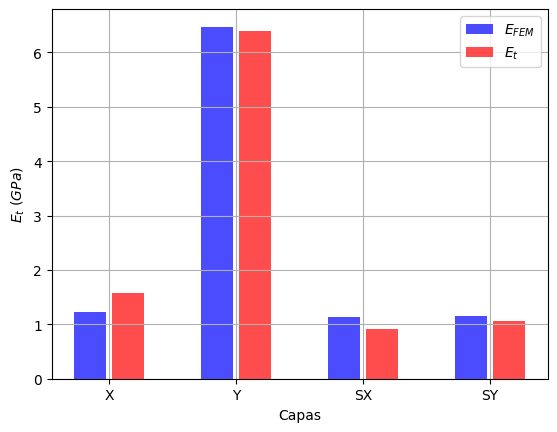

In [13]:
# bar plot 
from matplotlib import pyplot as plt

xrange = np.arange(len(E_effs))
plt.bar(xrange-0.15, E_effs,
         tick_label=names, color='blue', alpha=0.7,label=r"$E_{FEM}$",width=0.25)
plt.bar(xrange+ 0.15, E_target,
         tick_label=names, color='red', alpha=0.7,label=r"$E_{t}$",width=0.25)

plt.xticks(xrange, names, rotation=0)
plt.ylabel(r"$E_{t} \ (GPa)$")
plt.xlabel("Capas")
plt.grid()
plt.legend()

In [14]:
E_effs

[np.float64(1.220187776392606),
 np.float64(6.473557175974031),
 np.float64(1.1373904572080755),
 np.float64(1.14479434632592)]

In [15]:
E_target

array([1.58, 6.39, 0.92, 1.06])

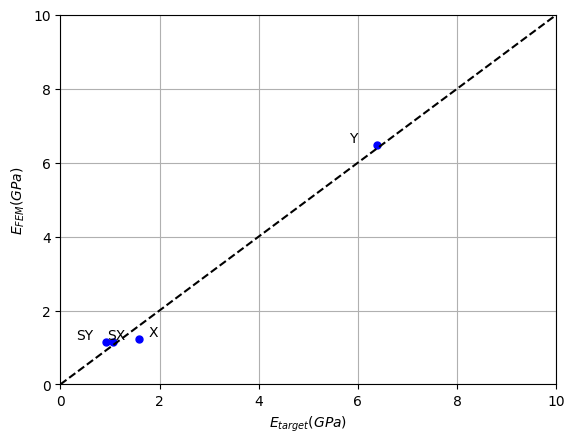

In [16]:
# 1vs1 

plt.figure()
plt.plot(E_target,E_effs, 'o', color='blue', label=r"$E_{FEM}$ vs $E_{target}$",ms=5)
plt.plot([0, 10], [0, 10], 'k--', label='1:1')
plt.ylabel(r"$E_{FEM} (GPa)$")
plt.xlabel(r"$E_{target} (GPa)$")
# text 
for i, txt in enumerate(names):

    if i % 2 == 0:
        disp =  0.4
    else:
        disp = -0.4
    plt.annotate(txt, (E_target[i]+disp, E_effs[i]), fontsize=10, ha='right', va='bottom')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid()

In [17]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [18]:
frds

['output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd',
 'output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd']

In [19]:

ifrd_s = [readfrd(f) for f in frds]

In [20]:
trajs = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["X","Y","SX","SY"] ]

In [21]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

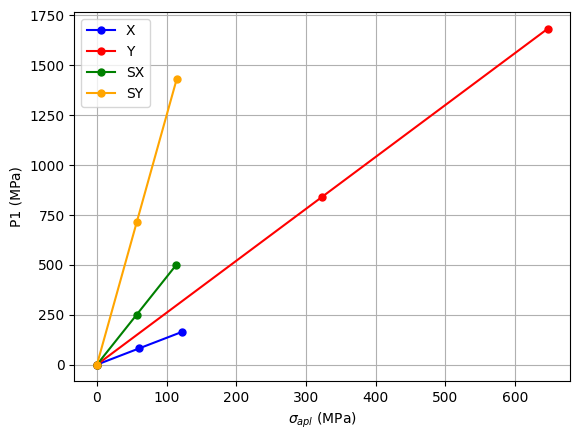

In [22]:
fig = plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for j in range(len(E_effs)):
    ifrd = ifrd_s[j]

    data_time = ifrd["data_blocks"]

    P1_max_list = []
    Sapl_list = []
    for i in range(len(data_time)):
        data = data_time[i]

        

        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)



        data = data[data["x"] > xmin]
        data = data[data["x"] < xmax]
        data = data[data["y"] > ymin]
        data = data[data["y"] < ymax]

        P1_max = np.max(data["P1"])
        P1_max_list.append(P1_max)

    P1_max_list = np.array(P1_max_list)
    Sapl_list = np.array(Sapl_list)



    plt.plot( Sapl_list,P1_max_list, 'o-', color=colors[j], label=names[j],ms=5)

plt.xlabel(r"$\sigma_{apl}$ (MPa)")
plt.ylabel(r"P1 (MPa)")
plt.grid()
plt.legend()
# plt.xlim(0, 200)

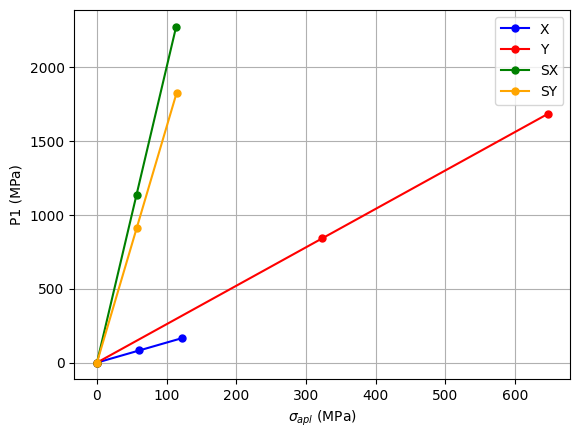

In [23]:
fig = plt.figure()
colors = ['blue', 'red', 'green', 'orange']

P1_time_design = []
Sapl_list_design = []

for j in range(len(E_effs)):
    ifrd = ifrd_s[j]

    data_time = ifrd["data_blocks"]

    P1_max_list = []
    Sapl_list = []
    for i in range(len(data_time)):
        data = data_time[i]


        P1_max = np.max(data["P1"])

        P1_max_list.append(P1_max)

        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)


    P1_max_list = np.array(P1_max_list)
    Sapl_list = np.array(Sapl_list)

        
    P1_time_design.append(P1_max_list)
    Sapl_list_design.append(Sapl_list)

    plt.plot( Sapl_list,P1_max_list, 'o-', color=colors[j], label=names[j],ms=5)

plt.xlabel(r"$\sigma_{apl}$ (MPa)")
plt.ylabel(r"P1 (MPa)")
plt.grid()
plt.legend()
# plt.xlim(0, 200)

In [24]:
ratio = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] 
         for ii in range(4)]
ratio = {
    "X": ratio[0],
    "Y": ratio[1],
    "SX":  ratio[2],
    "SY":  ratio[3]
}
ratio

{'X': np.float64(1.3573742115678893),
 'Y': np.float64(2.6016453678619613),
 'SX': np.float64(20.002735052366496),
 'SY': np.float64(15.966853423291552)}